# 🚨 Problematic APs Analysis
Este notebook identifica los puntos de acceso (APs) potencialmente problemáticos usando el dataset de muestra.

Criterios principales considerados (puedes ajustar pesos luego):

- Señal baja (dBm más negativo, fuerza 1-2)
- Porcentaje de conexiones con señal débil (< -60 dBm)
- SNR bajo
- Velocidad media baja
- Alta carga de clientes (número de conexiones)
- Estado del AP (si existe campo status)
- Recursos del AP (por ejemplo CPU/mem si están en datos de APs)

## 1. Importar librerías y utilidades

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings, sys
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', palette='pastel')
plt.rcParams.update({
  'figure.figsize': (12, 6),
  'axes.titlesize': 18,
  'axes.labelsize': 14
})

# Asegurar que utils esté accesible
UTILS_PATH = Path('../starter_kits/utils').resolve()
if str(UTILS_PATH) not in sys.path:
    sys.path.append(str(UTILS_PATH))
from data_loader import load_multiple_files, print_dataset_summary

## 2. Cargar datos (APs y Clientes)

In [2]:
ap_dir = Path('../samples/anonymized/ap')
clients_dir = Path('../samples/anonymized/clients')
df_aps = load_multiple_files(ap_dir, max_files=None, verbose=True)
df_clients = load_multiple_files(clients_dir, max_files=None, verbose=True)
print_dataset_summary(df_aps, 'APs (metadata)')
print_dataset_summary(df_clients, 'Clientes (conexiones)')

📁 Encontrados 1 archivos en ../samples/anonymized/ap
📊 Cargando todos archivos...
✅ Cargados 1169 registros de 1 archivos
💾 Memoria: 1.56 MB
📁 Encontrados 1 archivos en ../samples/anonymized/clients
📊 Cargando todos archivos...
✅ Cargados 10487 registros de 1 archivos
💾 Memoria: 18.82 MB

📊 RESUMEN: APs (metadata)

🔢 Registros totales: 1,169
📝 Columnas: 32
💾 Memoria: 1.56 MB

📋 Columnas disponibles:
   • ap_deployment_mode             (100.0% completo)
   • ap_group                       ( 25.8% completo)
   • client_count                   (100.0% completo)
   • cluster_id                     (100.0% completo)
   • controller_name                (100.0% completo)
   • cpu_utilization                (100.0% completo)
   • firmware_version               (100.0% completo)
   • gateway_cluster_id             (100.0% completo)
   • gateway_cluster_name           (100.0% completo)
   • group_name                     (100.0% completo)
   ... y 22 columnas más



📊 RESUMEN: Clientes (conexion

## 3. Agregar métricas por AP (lado Clientes)
A partir de conexiones de clientes, calculamos métricas por `associated_device_name` (nombre del AP):
- `conn_count`: número de registros/conexiones
- `avg_signal_db`: señal promedio (dBm)
- `weak_pct`: % de conexiones con señal < -60 dBm
- `avg_snr`: SNR promedio
- `avg_speed`: velocidad media

In [6]:
ap_name_col = 'associated_device_name'
required_cols = [ap_name_col, 'signal_db', 'snr', 'speed']
missing = [c for c in required_cols if c not in df_clients.columns]
if missing:
    raise ValueError(f'Faltan columnas en df_clients: {missing}')

# Marcar señal débil (< -60 dBm)
df_clients['weak_signal'] = df_clients['signal_db'] < -60

# Agregación por AP
ap_metrics = (
    df_clients.groupby(ap_name_col)
              .agg(
                  conn_count=('macaddr', 'count'),
                  avg_signal_db=('signal_db', 'mean'),
                  weak_pct=('weak_signal', 'mean'),
                  avg_snr=('snr', 'mean'),
                  avg_speed=('speed', 'mean')
              )
              .reset_index()
)

# Escalas y saneos básicos
ap_metrics['weak_pct'] = (ap_metrics['weak_pct'] * 100).round(2)
ap_metrics['avg_signal_db'] = ap_metrics['avg_signal_db'].round(1)
ap_metrics['avg_snr'] = ap_metrics['avg_snr'].round(1)
ap_metrics['avg_speed'] = ap_metrics['avg_speed'].round(1)

ap_metrics.head()

,associated_device_name,conn_count,avg_signal_db,weak_pct,avg_snr,avg_speed
0,\tAP-DRET33,2,-59.0,50.00,37.0,124.5
1,\tAP-DRET34,3,-61.0,33.33,35.0,160.5
2,AP-CIEN60,1,NaN,0.00,NaN,NaN
3,AP-AMICSUAB01,2,-77.0,50.00,19.0,14.0
4,AP-AMICSUAB02,4,-66.0,50.00,29.7,78.3


## 4. Unir con metadata de APs (CPU/Mem/Estado cuando exista)

In [8]:
# df_aps típicamente tiene una fila por AP. Nombre del AP en columna 'name'.
meta_cols = ['name','status','client_count','cpu_utilization','mem_free','mem_total','model','site']
meta_cols = [c for c in meta_cols if c in df_aps.columns]
df_meta = df_aps[meta_cols].drop_duplicates(subset=['name']) if 'name' in meta_cols else pd.DataFrame()
# Merge metrics (clients) with meta (aps)
df_join = ap_metrics.merge(df_meta, left_on=ap_name_col, right_on='name', how='left') if not df_meta.empty else ap_metrics.copy()
# Derivar ratio de memoria si hay datos
if {'mem_free','mem_total'}.issubset(df_join.columns):
    df_join['mem_used_pct'] = (1 - (df_join['mem_free'] / df_join['mem_total']).clip(lower=0, upper=1)) * 100
df_join.head()

,associated_device_name,conn_count,avg_signal_db,weak_pct,avg_snr,avg_speed,name,status,client_count,cpu_utilization,mem_free,mem_total,model,site,mem_used_pct
0,\tAP-DRET33,2,-59.0,50.00,37.0,124.5,\tAP-DRET33,Up,3.0,2.0,788811776.0,1.787482e+09,635,UAB,55.870228
1,\tAP-DRET34,3,-61.0,33.33,35.0,160.5,\tAP-DRET34,Up,0.0,2.0,749247680.0,1.787482e+09,635,UAB,58.083626
2,AP-CIEN60,1,NaN,0.00,NaN,NaN,AP-CIEN60,Up,3.0,6.0,784167744.0,1.787482e+09,635,UAB,56.130037
3,AP-AMICSUAB01,2,-77.0,50.00,19.0,14.0,AP-AMICSUAB01,Up,1.0,4.0,741854400.0,1.787482e+09,635,UAB,58.497241
4,AP-AMICSUAB02,4,-66.0,50.00,29.7,78.3,AP-AMICSUAB02,Up,4.0,2.0,741038464.0,1.787482e+09,635,UAB,58.542888


## 5. Scoring de 

Combinamos métricas en una puntuación (más alto = más problemático).
Pesos iniciales (ajustables):
- Señal (dBm): 0.30 (más negativo = peor)
- Weak %: 0.30
- SNR: 0.15 (más bajo = peor)
- Speed: 0.10 (más baja = peor)
- Carga (conn_count): 0.10
- Estado/Recursos: 0.05 (considera mem_used_pct o cpu si están)

In [9]:
df = df_join.copy()
# Normalizaciones: escalar a [0,1] donde 1 = peor

def norm01(series, invert=False):
    s = series.astype(float)
    rng = s.max() - s.min()
    if rng == 0 or np.isinf(rng) or np.isnan(rng):
        return pd.Series(0.5, index=s.index)
    n = (s - s.min()) / rng
    return 1 - n if invert else n

# Construir marco de puntuaciones
score = pd.DataFrame({
    'ap': df[ap_name_col],
    'weak_norm': norm01(df['weak_pct']),
    'signal_norm': norm01(-df['avg_signal_db']),  # más negativo => peor
    'snr_norm': norm01(-df['avg_snr']),           # menor => peor
    'speed_norm': norm01(-df['avg_speed']),       # menor => peor
    'load_norm': norm01(df['conn_count'])
})

# Recursos si existen
if 'mem_used_pct' in df.columns:
    score['mem_norm'] = norm01(df['mem_used_pct'])
else:
    score['mem_norm'] = 0

if 'cpu_utilization' in df.columns:
    score['cpu_norm'] = norm01(df['cpu_utilization'])
else:
    score['cpu_norm'] = 0

# Pesos
w = {
    'weak_norm': 0.30,
    'signal_norm': 0.30,
    'snr_norm': 0.15,
    'speed_norm': 0.10,
    'load_norm': 0.10,
    'mem_norm': 0.03,
    'cpu_norm': 0.02
}

score['problem_score'] = (
    score['weak_norm']*w['weak_norm'] +
    score['signal_norm']*w['signal_norm'] +
    score['snr_norm']*w['snr_norm'] +
    score['speed_norm']*w['speed_norm'] +
    score['load_norm']*w['load_norm'] +
    score['mem_norm']*w['mem_norm'] +
    score['cpu_norm']*w['cpu_norm']
)

# Top problemáticos
top_bad = score.sort_values('problem_score', ascending=False).head(20)
top_bad.head(10)

,ap,weak_norm,signal_norm,snr_norm,speed_norm,load_norm,mem_norm,cpu_norm,problem_score
86,AP-CCOM27,1.0,1.000000,1.000000,0.991228,0.012987,0.591501,0.094595,0.870058
746,AP-MED23,1.0,0.970874,0.990291,0.982456,0.000000,0.565348,0.121622,0.857444
151,AP-CEDU58,1.0,0.970874,0.970874,0.982456,0.000000,0.523579,0.067568,0.852198
84,AP-CCOM21,1.0,0.947573,0.947573,0.982456,0.038961,0.624461,0.094595,0.849175
775,AP-MED62,1.0,0.970874,0.970874,1.000000,0.000000,0.283675,0.108108,0.847566
377,AP-ECOSOC04,1.0,0.970874,0.970874,0.991228,0.012987,0.276817,0.027027,0.846160
635,AP-LLET126,1.0,0.970874,0.970874,0.982456,0.000000,0.309786,0.013514,0.844703
497,AP-ETSE73,1.0,0.932039,0.951456,0.982456,0.000000,0.634415,0.081081,0.841230
504,AP-EUREKA01,1.0,0.951456,0.951456,0.982456,0.000000,0.420408,0.027027,0.839554
693,AP-LLET61,1.0,0.932039,0.932039,0.982456,0.000000,0.296349,0.270270,0.831959


## 6. Visualizaciones

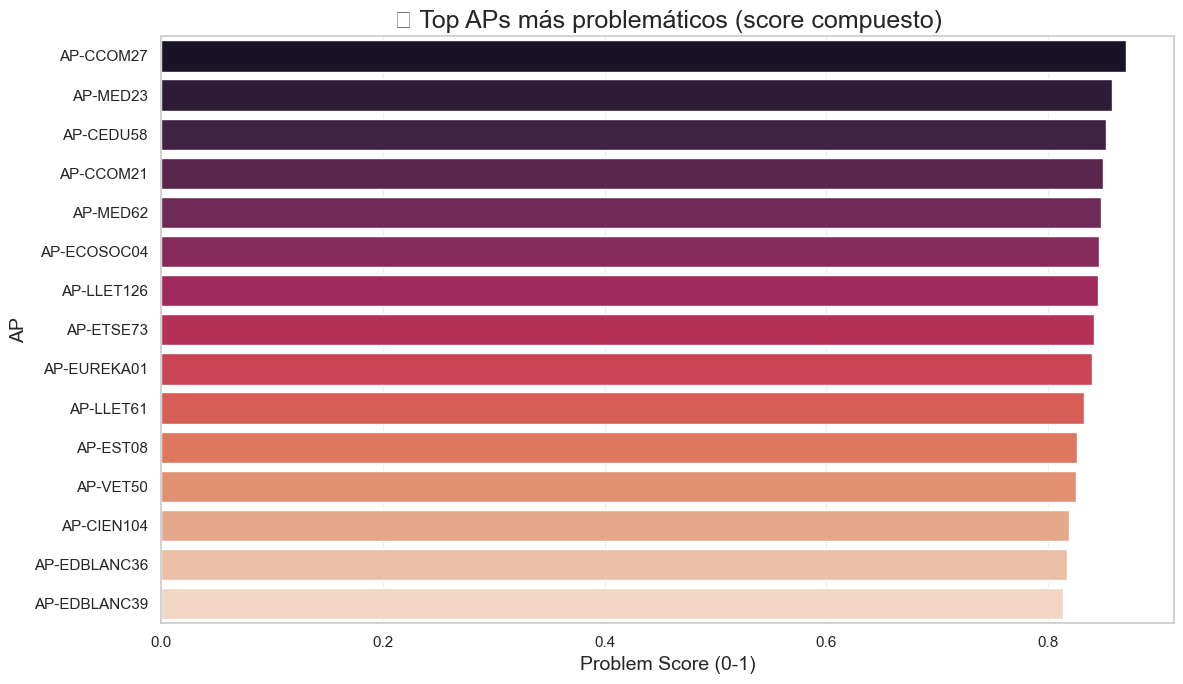

In [10]:
# Top 15 más problemáticos
plt.figure(figsize=(12, 7))
sns.barplot(data=top_bad.head(15), x='problem_score', y='ap', orient='h', palette='rocket')
plt.title('🚨 Top APs más problemáticos (score compuesto)')
plt.xlabel('Problem Score (0-1)')
plt.ylabel('AP')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

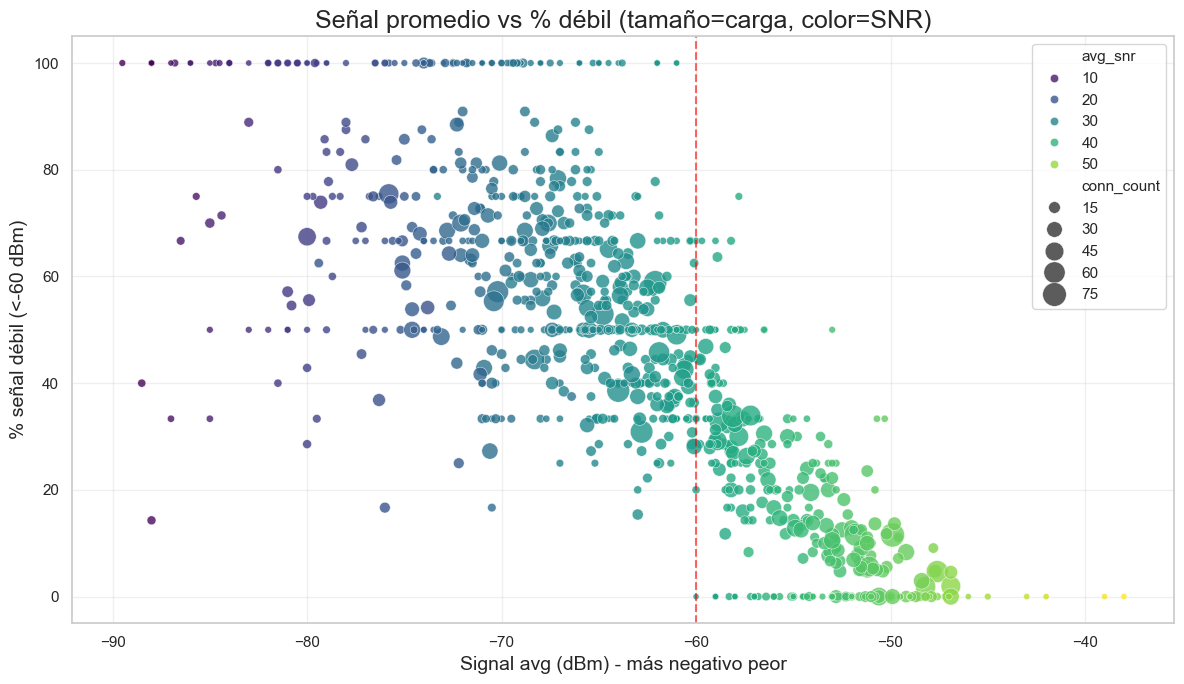

In [11]:
# Diagrama de dispersión: Señal promedio vs % señal débil (tamaño=carga)
plt.figure(figsize=(12,7))
tmp = df.copy()
sns.scatterplot(data=tmp, x='avg_signal_db', y='weak_pct', size='conn_count', sizes=(20, 300), hue='avg_snr', palette='viridis', alpha=0.8)
plt.axvline(-60, color='red', linestyle='--', alpha=0.6)
plt.title('Señal promedio vs % débil (tamaño=carga, color=SNR)')
plt.xlabel('Signal avg (dBm) - más negativo peor')
plt.ylabel('% señal débil (<-60 dBm)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Recomendaciones (borrador)
- Revisar APs con mayor `problem_score` (top 10).
- Para APs con `weak_pct` alto y señal promedio muy negativa: considerar reubicación o ajuste de potencia/canal.
- Para APs con `conn_count` excesivo: balancear carga (band steering, más APs, reconfiguración).
- Verificar `status` y recursos (CPU/mem) si están altos o AP en fallo.